<a href="https://colab.research.google.com/github/vu-bigdata-2020/example-notebooks/blob/master/analytics-examples/traffic_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Traffic Visualization and Analysis

##### In this notebook we will use traffic data from Nashville, TN and show how to visualize the data on map and do some basic analysis.

##### At first we wil import some libraries necessary for this job.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import json
from copy import deepcopy
from shapely.geometry import *
from shapely.ops import cascaded_union
import folium
import random
import matplotlib

We will use the data from HERE API where the road segments are represented in terms of Traffic Message Channels(TMC).


TMC : An edge with traffic speed data associated with it.


Now we will load a json file to load the TMC numbers and the associated longitudes and latitudes presented in form of linestrings.

In [0]:
tmc_data_path = "https://raw.githubusercontent.com/vu-bigdata-2020/example-notebooks/master/datasets/traffic_data/tmc.json"

In [0]:
import urllib

url = tmc_data_path

response = urllib.request.urlopen(url)
tmc_json = json.loads(response.read())
# print (tmc_json.keys())


Once the data is loaded, we will plot the data on the map.

We define a function for that as described below.

In [0]:
def plot_tmc_ids(tmc_id_list, color="blue"):
    """
    tmc_id_list: (type-list) list of tmc IDs
    """
    shp_list = [asShape(tmc_json[tmc_id]["tmc_shp"]) for tmc_id in tmc_id_list]
    shp = cascaded_union(shp_list)
    center = shp.centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=13)
    bounds = shp.bounds
    m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
    style =lambda x: {'color' :color}
    folium.GeoJson(mapping(shp), style_function=style).add_to(m)
    folium.LayerControl().add_to(m)
    return m

This notebook uses the preprocessed data in terms of .npy files.

The original data containing the information about traffic speed, jam factor, free flow speed etc. is in parquet format and is of size 28 GB. 

We preprocessed the data and extracted the total list of TMC IDs (stored in 'fti.npy'), the average maximum speed per TMC (stored in 'fulldatamaxspeed.npy'), the matrix containing average traffic speed at an interval of 10 minutes for all the TMCs for just five days (starting from January 1,2018 to January 5, 2018, stored in 'fivedaysdata.npy').

These preprocessed files will be used for further analysis.

Next we load the full list of TMC IDs stored in a .npy file.

In [0]:
import requests

In [0]:
r2 = requests.get('https://raw.githubusercontent.com/vu-bigdata-2020/example-notebooks/master/datasets/traffic_data/fti.npy')

In [44]:
r2

<Response [200]>

In [0]:
f = open('fti.npy', 'wb')
f.write(r2.content)
f.close()

In [0]:
fti = np.load('fti.npy',allow_pickle=True)

Let's see how many TMC IDs are there in Nashville.

In [47]:
np.shape(fti)

(3724,)

We have a total of 3724 TMC IDs. Let' print some of them.

In [74]:
fti[0:10]

array(['10727+0.88218', '10727-1.4957', '10729-0.05757', '10731-0.07415',
       '10733-0.78909', '10735-0.56537', '10737-0.40404', '10739-0.18857',
       '10741-0.26559', '10741-0.2656'], dtype=object)

Let's plot some TMC IDs

In [77]:
plot_tmc_ids(['12331-0.25626','12333-0.41623','12426+0.48088'])

The average maximum speed per TMC is stored in a numpy matrix 'fulldatamaxspeed.npy'. We load that next.

In [0]:
r3 = requests.get('https://raw.githubusercontent.com/vu-bigdata-2020/example-notebooks/master/datasets/traffic_data/fulldatamaxspeed.npy')

In [18]:
r3

<Response [200]>

In [0]:
f2 = open('fulldatamaxspeed.npy', 'wb')
f2.write(r3.content)
f2.close()

In [0]:
maxspeed = np.load('fulldatamaxspeed.npy',allow_pickle=True)

In [22]:
np.shape(maxspeed)

(3724,)

Starting from January 1st 2018, we load the data for first five days which has already been preprocessed and normalized and contains data an interval of 10 minutes for each TMC ID. 

So for each day we have 6*24=144 entries for each TMC ID. 

In [0]:
r4 = requests.get('https://raw.githubusercontent.com/vu-bigdata-2020/example-notebooks/master/datasets/traffic_data/fivedaysdata.npy')

In [24]:
r4

<Response [200]>

In [0]:
f3 = open('fivedaysdata.npy', 'wb')
f3.write(r4.content)
f3.close()

In [0]:
fivedays_data = np.load('fivedaysdata.npy', allow_pickle=True)

In [27]:
np.shape(fivedays_data)

(721, 3724)

In [0]:
def is_nan(x):
  return (x is np.nan or x != x)

Next we define a function to plot the actual speed of any TMC ID with a given time window.

The arguments are:

tmc_num: TMC ID

start_day_num: As we have only five days' data, this variable can vary from 0 to 4.

end_day_num: As we have only five days' data, this variable can vary from 0 to 4 and is >= start_day_num

start_hour: The hour from which we want to start plotting the data (varies between 0 to 24 (integer only))

end_hour: The hour upto which we want to plot the data (varies between 0 to 24 (integer only))




In [0]:
def plot_speed(tmc_num, start_day_num, end_day_num, start_hour, end_hour):
  if (is_nan(fivedays_data[:,tmc_num])[0] == True):
    print ("We do not have data for that particular TMC. Please input any other TMC number.")
  else:
    max_tmc_speed = maxspeed[tmc_num]
    start_ind = start_day_num*144 + start_hour*6
    end_ind = end_day_num*144 + end_hour*6
    plt.plot(fivedays_data[start_ind:end_ind, tmc_num]*max_tmc_speed,'-*', color = 'black')
    plt.xlabel('Time instance(10 minute interval)')
    plt.ylabel('Speed')
    plt.show()

Example:

Let's plot for TMC number 1 as stored in the array 'fti' from 9:00 a.m. on day 2 to 5:00 p.m. (17:00 hours) on day 3.

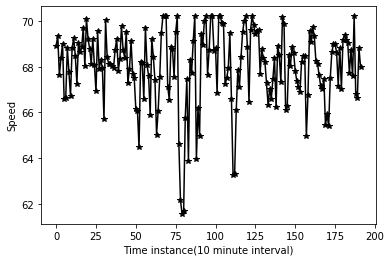

In [42]:
plot_speed(1,2,3, 9,17)

### Find the average speed for the first 100 TMCs at 9:00 a.m. on January 1, 2018.

In [78]:
slist = []
tlist = []
for i in range(100):
  if (is_nan(fivedays_data[:,i])[0] == False):
    slist.append(fivedays_data[9*6, i]*maxspeed[i])
    tlist.append(i)
avg_speed = np.mean(slist)
print ("The average speed for the first 100 TMCs at 9:00 a.m. on January 1, 2018.", avg_speed, "MPH")


The average speed for the first 100 TMCs at 9:00 a.m. on January 1, 2018. 44.89252597666613 MPH


Let's plot those 100 TMCs

In [72]:
aa=fti[0:100]
plot_tmc_ids(aa)

Let's find out which one of them had the highest speed at 9:00 a.m. on January 1, 2018 (day 1 in our case)

In [70]:
highest_speed_tmc = tlist[np.argmax(slist)]
plot_tmc_ids([fti[highest_speed_tmc]])

We see that's an interstate. This particular road segment had the highest speed at that particular time among the 100 TMCs we considered.